In [1]:
import os
os.environ['MACOSX_DEPLOYMENT_TARGET'] = '10.9' # HACK: needed for stan...

import astropy.coordinates as coord
from astropy.table import Table, join, hstack
import astropy.units as u
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pystan

from pyia import GaiaData

In [2]:
sm = pystan.StanModel('../stan/plz.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5fa9bbb8083cdec384c8bd3691721879 NOW.


In [3]:
tbl1 = Table.read('/Users/adrian/data/GaiaDR2/rrlyrae.fits')
tbl2 = Table.read('/Users/adrian/data/GaiaDR2/vari_rrlyrae.fits')
tbl1.meta = None
tbl2.meta = None
tbl2 = tbl2[[x for x in tbl2.colnames if x not in tbl1.colnames or x == 'source_id']]
tbl = join(tbl1, tbl2, keys='source_id')

In [4]:
g = GaiaData(tbl)
c = g.get_skycoord(distance=False)

In [5]:
k2014 = Table.read('/Users/adrian/data/Misc/Klein2014_rrlyrae.fit')
kc = coord.SkyCoord(k2014['_RA'], k2014['_DE'], unit=u.deg)

In [59]:
idx, sep, _ = kc.match_to_catalog_sky(c)
join_tbl = hstack((tbl[idx[sep < 5*u.arcsec]], k2014[sep < 5*u.arcsec]))
# join_tbl = tbl

g = GaiaData(join_tbl)
g.data['ebv'] = g.get_ebv()

In [60]:
plx_snr_mask = (g.parallax / g.parallax_error) > 10
# plx_snr_mask = np.ones(len(g), dtype=bool)

rp_nobs_mask = g.phot_rp_n_obs >= 20
# rp_good_mask = np.isfinite(g.int_average_rp)
rp_good_mask = np.isfinite(g.W1mag.value)

feh_mask = np.isfinite(g.metallicity) & (g.metallicity.value > -3) & (g.metallicity.value < 0)
ab_mask = g.best_classification == 'RRab'
ebv_mask = g.ebv < 0.5
pf_mask = (g.pf > 0.1*u.day) & (g.pf < 1*u.day)

M = g.int_average_rp.value - g.get_distance(allow_negative=True).distmod.value
abs_rp_mask = M < 1.

all_mask = plx_snr_mask & rp_nobs_mask & rp_good_mask & feh_mask & ab_mask & ebv_mask & pf_mask & abs_rp_mask
sub_g = g[all_mask]

# HACK:
sub_g = sub_g[sub_g.parallax > 0.5*u.mas]
len(sub_g)

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in greater
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less
/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adrian/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in less
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in less


37

In [61]:
data = dict()

data['n_stars'] = len(sub_g)
data['Alambda'] = 0.1
# kRP = 0.6104 # from https://www.aanda.org/articles/aa/pdf/2018/08/aa32843-18.pdf - taking just c1
# data['Alambda'] = kRP * 3.1

data['plx'] = sub_g.parallax.value
data['plx_err'] = sub_g.parallax_error.value

# data['mag'] = sub_g.int_average_rp.value
# data['mag_err'] = sub_g.int_average_rp_error.value
data['mag'] = sub_g.W1mag.value
data['mag_err'] = sub_g.e_W1mag.value

data['EBV'] = sub_g.get_ebv()
data['EBV_err'] = 0.1 * data['EBV']

data['FeH'] = sub_g.metallicity.value
data['FeH_err'] = sub_g.metallicity_error.value

data['log10P'] = np.log10(sub_g.pf.value)
data['log10P_err'] = np.log10(np.e) * (sub_g.pf_error.value / sub_g.pf.value)

# Sesar+2017
data['log10P_ref'] = np.log10(0.52854)
data['FeH_ref'] = -1.4

In [62]:
plx_samples = np.random.normal(sub_g.parallax.value, sub_g.parallax_error.value,
                               size=(1024, len(sub_g)))
DM_samples = coord.Distance(parallax=plx_samples * sub_g.parallax.unit).distmod.value
DM_err = np.std(DM_samples, axis=0)

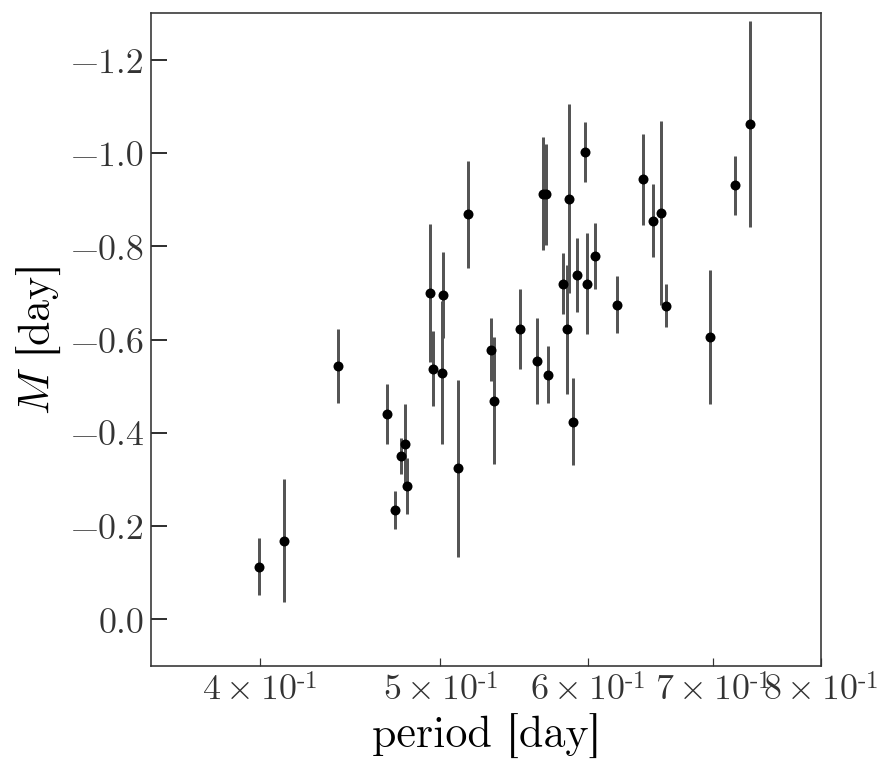

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.errorbar(sub_g.pf.value, data['mag'] - sub_g.distmod.value, 
            yerr=np.sqrt(data['mag_err']**2 + DM_err**2), 
            marker='o', ls='none', ecolor='#555555', color='k')

ax.set_xlabel('period [day]')
ax.set_ylabel('$M$ [day]')

ax.set_xlim(0.35, 0.8)
ax.set_ylim(0.1, -1.3)
# ax.set_ylim(1.5, -0.5)

ax.set_xscale('log')

In [48]:
init = dict()

init['ln_s_M'] = np.log(0.1)
init['plx0'] = 0.
init['ln_sig_plx_add'] = np.log(1e-8)
init['f_plx'] = 1.

init['r'] = 1000 / sub_g.parallax.value
init['L'] = 250.
init['FeH_int'] = data['FeH']
# init['EBV_int'] = data['EBV']
# init['log10P_int'] = data['log10P']

init['a'] = -2.
init['b'] = 0.15
init['M_ref'] = -0.5

In [57]:
fit = sm.optimizing(data=data, init=init, iter=4096)
samples = sm.sampling(data=data, chains=1, init=[fit], control=dict(adapt_delta=1))

In [50]:
fit

OrderedDict([('ln_s_M', array(-9.37001973)),
             ('plx0', array(-0.03823711)),
             ('ln_sig_plx_add', array(-18.42068074)),
             ('r',
              array([1644.53609847, 1770.54782119, 1571.95791483, 1412.34036642,
                      689.25511105, 1094.72802133,  726.14189753, 1176.32388749,
                      590.8231161 , 1060.61236108, 1491.77632489, 1784.71683751,
                     1756.26239937, 1377.22016996, 1514.83170406,  939.19746209,
                     1289.54087517, 1675.64682219, 2092.72388907,  988.58491269,
                     1570.10538565,  568.87444167, 1736.41946811,  951.7147031 ,
                     1101.80014821, 1408.62391179, 1449.29280639, 1647.56099793,
                     2026.8121843 ,  726.51760229, 1276.42208137, 1505.13691133,
                     1315.34533335,  807.26405505, 1613.26240686, 1005.64343152,
                     1422.4721364 ,  597.95234747, 1148.91491052, 1731.18158902,
                     1605.764

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in log10


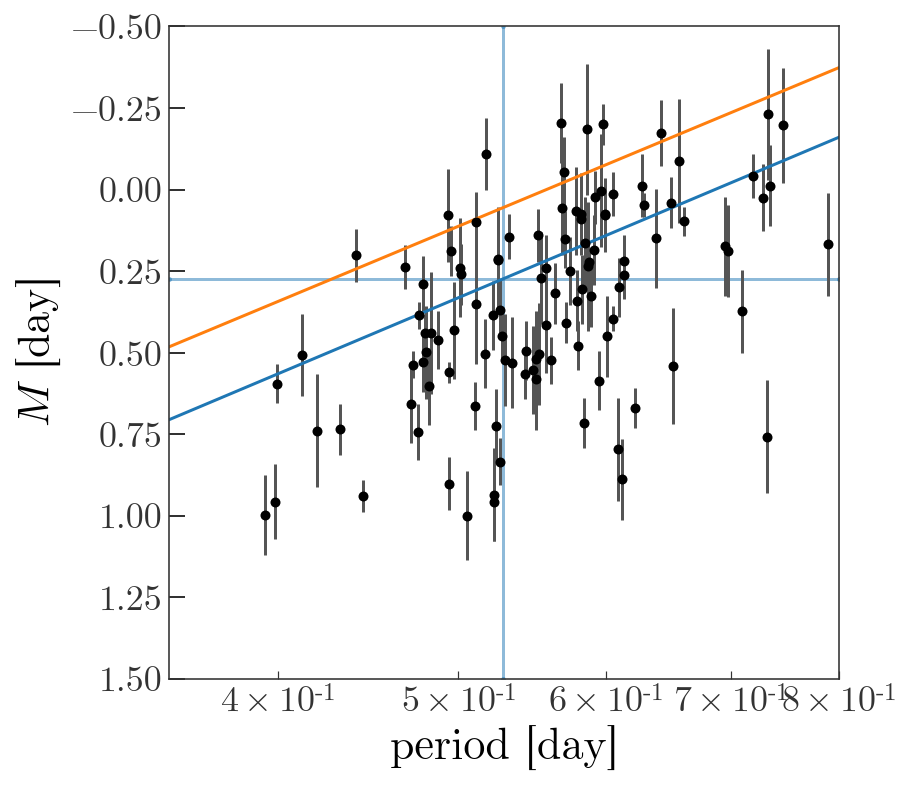

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.errorbar(sub_g.pf.value, data['mag'] - sub_g.distmod.value, 
            yerr=np.sqrt(data['mag_err']**2 + DM_err**2), 
            marker='o', ls='none', ecolor='#555555', color='k')

xx = np.linspace(0., 1, 128)
# for feh in np.arange(-2.5, -0.5+1e-3, 0.5):
#     M = (fit['a'] * (np.log10(xx) - data['log10P_ref']) +
#          # fit['b'] * (feh - data['FeH_ref']) +
#          fit['M_ref'])
#     ax.plot(xx, M, marker='')
    
M = fit['a'] * (np.log10(xx) - data['log10P_ref']) + fit['M_ref']
ax.plot(xx, M, marker='')
     
M = np.mean(samples['a']) * (np.log10(xx) - data['log10P_ref']) + np.mean(samples['M_ref'])
ax.plot(xx, M, marker='')

ax.set_xlabel('period [day]')
ax.set_ylabel('$M$ [day]')

ax.set_xlim(0.35, 0.8)
# ax.set_ylim(0.1, -1.3)
ax.set_ylim(1.5, -0.5)

ax.set_xscale('log')

ax.axvline(10 ** data['log10P_ref'], zorder=-100, color='tab:blue', alpha=0.5)
ax.axhline(fit['M_ref'], zorder=-100, color='tab:blue', alpha=0.5)

(-0.1, 0.1)

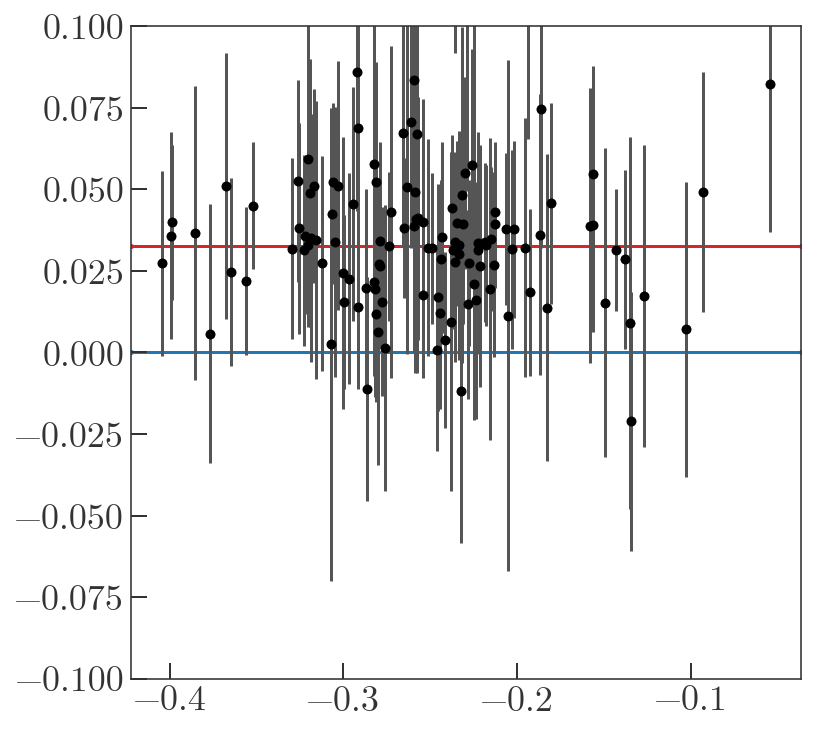

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# ax.errorbar(data['log10P'], data['plx'] - 1000 / fit['r'], data['plx_err'], ls='none')
ax.errorbar(data['log10P'], data['plx'] - 1000 / np.mean(samples['r'], axis=0), 
            data['plx_err'], 
            marker='o', ls='none', ecolor='#555555', color='k')

ax.axhline(np.mean(samples['plx0']), color='tab:red', zorder=-10)

ax.axhline(0, color='tab:blue', zorder=-100)
ax.set_ylim(-0.1, 0.1)